In [20]:
from openparticle import *
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 270

# Quartic Oscillator

$$
H = a^\dagger a + g (a + a^\dagger)^4
$$

In [2]:
N = 200
n = 3
g = 1

In [4]:
def one_ge(matrix):
    n = len(matrix) - 1
    A_eff = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            A_eff[i][j] = matrix[i][j] - g * (matrix[i][n] * matrix[n][j])/(matrix[n][n])

    return A_eff

def ge_matrix(matrix, n):

    N = len(matrix)

    for _ in range(N - n):
        matrix = one_ge(matrix)

    return matrix

def matrix_element(k, l, g):
    return (k + 3 * g * (2 * k ** 2 + 2 * k + 1)) * delta(k, l) +\
            g * (4 * l + 6) * np.sqrt((l + 1) * (l + 2)) * delta(k, l + 2) +\
            g * (4 * k + 6) * np.sqrt((k + 1) * (k + 2)) * delta(k + 2, l) +\
            g * np.sqrt((l + 1) * (l + 2) * (l + 3) * (l + 4)) * delta(k, l + 4) +\
            g * np.sqrt((k + 1) * (k + 2) * (k + 3) * (k + 4)) * delta(k + 4, l) 

def delta(k, l):
    if k == l: return 1 
    return 0

def get_matrix(N):
    H = np.zeros((N + 1, N + 1))
    
    for i in range(N + 1):
        for j in range(N + 1):
            H[i][j] = matrix_element(i, j, g)

    return H


Text(0.5, 1.0, 'Full $201x201$ Hamiltonian')

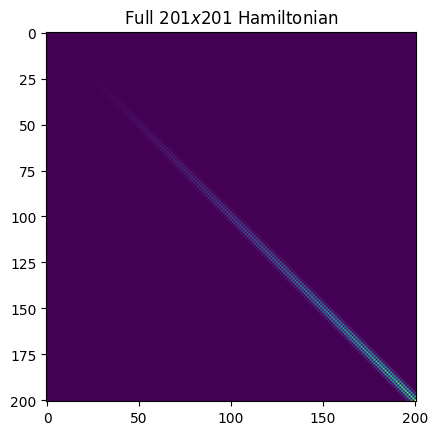

In [11]:
Hfull = get_matrix(N)
plt.imshow(np.real(
    Hfull
))
plt.title(f"Full ${N + 1}x{N + 1}$ Hamiltonian")

Text(0.5, 1.0, 'Effective $4x4$ Hamiltonian')

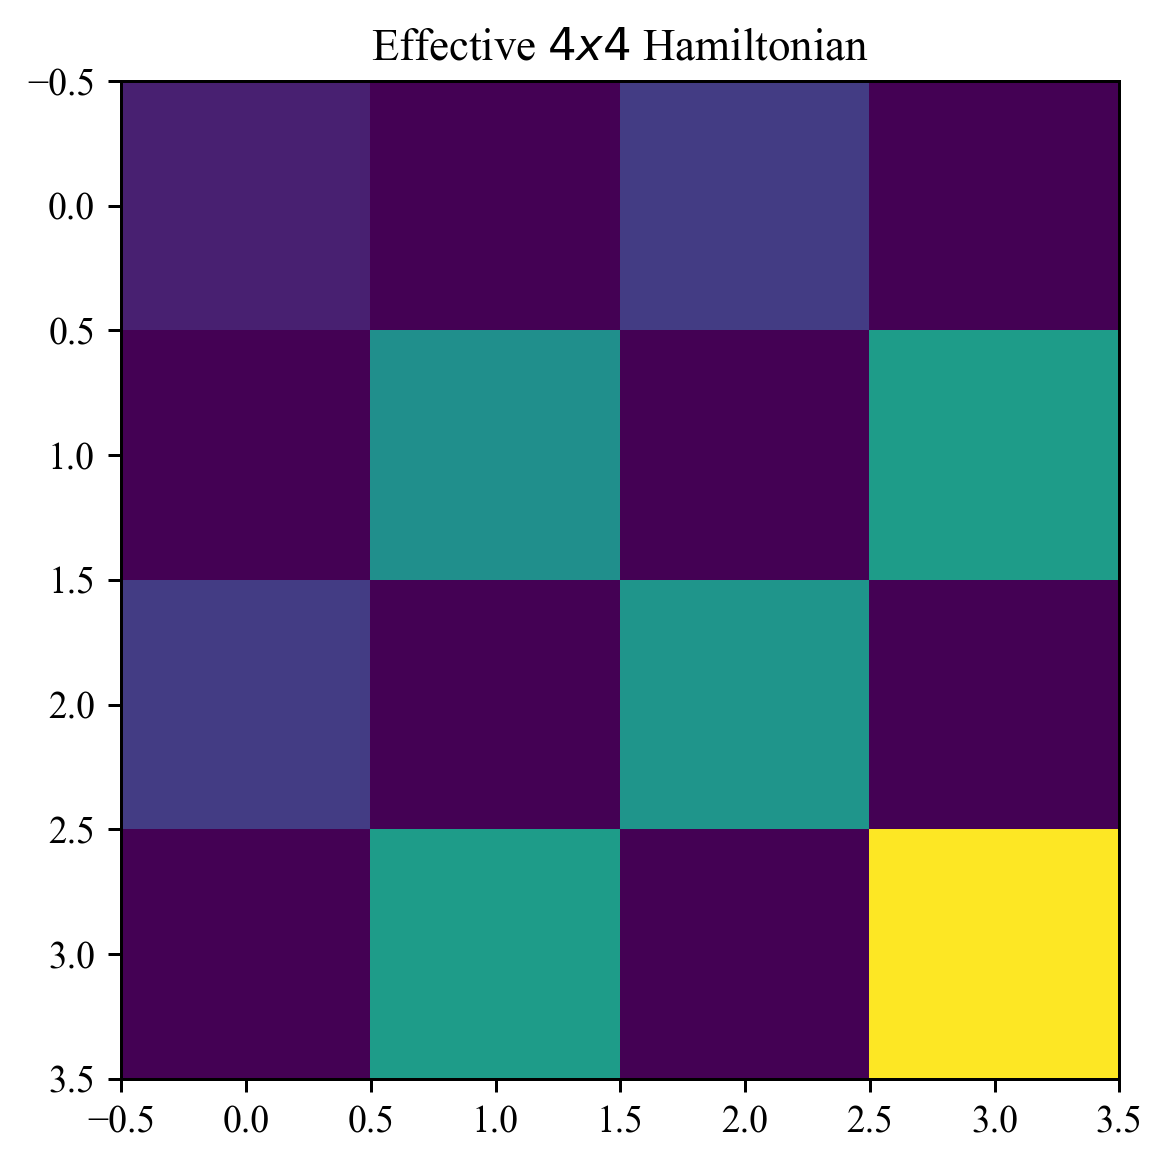

In [21]:
Heff = ge_matrix(get_matrix(N), n + 1)
plt.imshow(np.real(
    Heff
))
plt.title(f"Effective ${n + 1}x{n + 1}$ Hamiltonian")

### Check energy Eigenvalues

In [13]:
full_vals = np.linalg.eigvalsh(Hfull)
eff_vals = np.linalg.eigvalsh(Heff)

print("E0_full:", min(full_vals))
print("E0_eff:", min(eff_vals))

E0_full: 0.648788914126484
E0_eff: 0.6626769464339801


In [24]:
def get_basis(N):
    return [Fock([], [], [(0, l)]) for l in range(N + 1)]

In [25]:
def better_overlap(i, j):
    key_overlap = i.state_dict.keys() & j.state_dict.keys()
    if key_overlap == {}:
        return 0
    else:
        overlap = 0
        for key in key_overlap:
            overlap += i.state_dict[key] * j.state_dict[key]

        return overlap
    
def better_matrix_generation(N):
    H = ParticleOperator('a0^ a0') + g * (ParticleOperator('a0^') + ParticleOperator('a0'))**4
    basis = get_basis(N)
    matrix = np.zeros((N + 1, N + 1), dtype=complex)

    for j, state_j in enumerate(basis):
        rhs = H * state_j
        for i, state_i in enumerate(basis):
            if i <= j:
                mval = better_overlap(state_i, rhs)
                matrix[i][j] = matrix[j][i] = mval

    return matrix

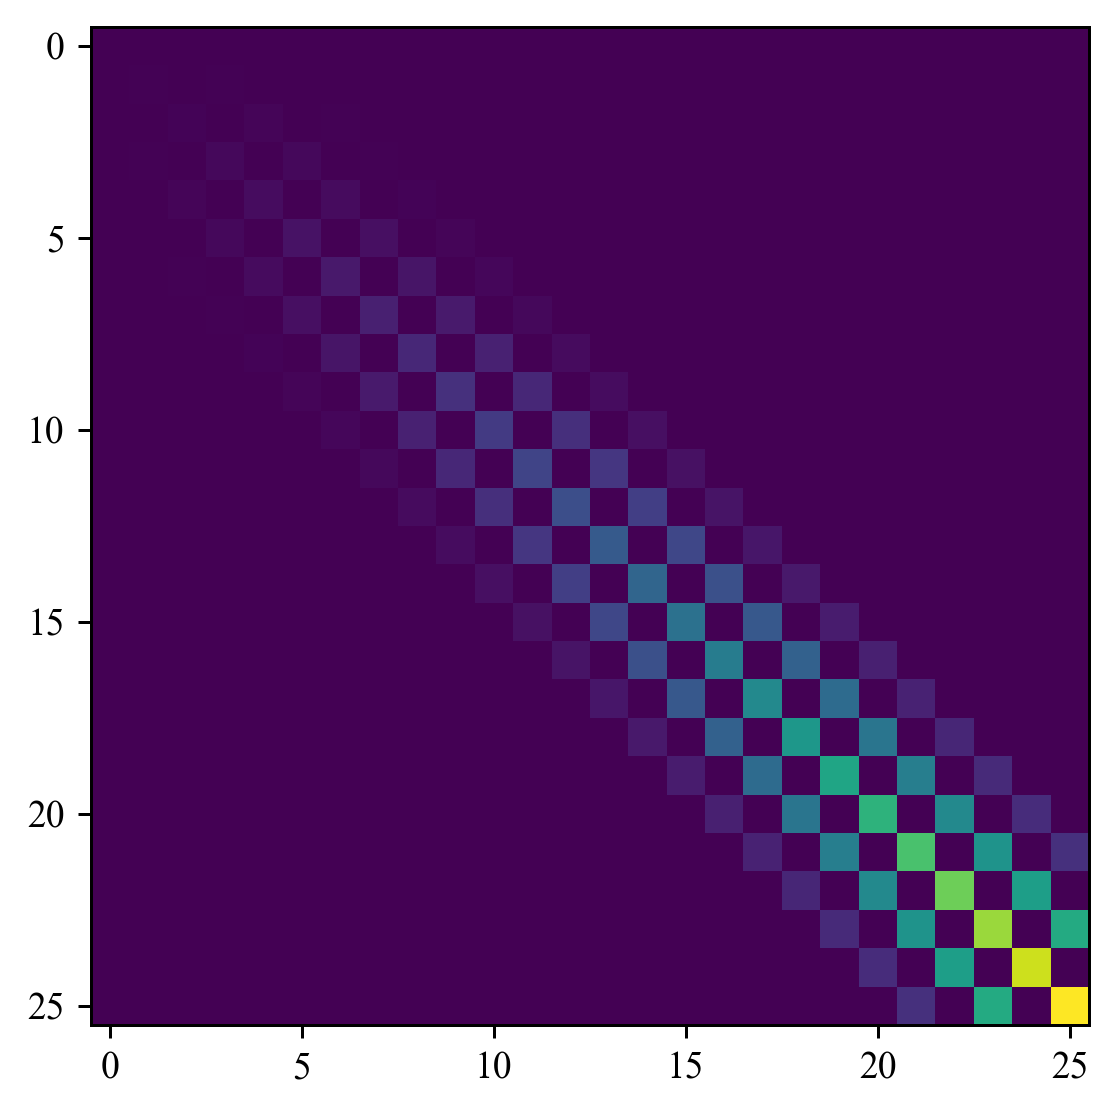

In [26]:
plt.imshow(np.real(better_matrix_generation(25)))

In [40]:
def renormalized_H_op(N, n):
    H = ParticleOperator('a0^ a0') + g * (ParticleOperator('a0^') + ParticleOperator('a0'))**4
    
    full_matrix = get_matrix(N)
    Heff = ge_matrix(full_matrix, n + 1)

    def delta_H(i, j):
        return (Heff[:,:])[i,j] - full_matrix[i,j]
    
    H_eff_op = H + (
        delta_H(n - 3, n - 3) / math.factorial(n - 3) * ParticleOperator('a0^') ** (n - 3) * ParticleOperator('a0') ** (n - 3) - 
        delta_H(n - 3, n - 3) / math.factorial(n - 3) * (ParticleOperator('a0^') ** (n - 2) * ParticleOperator('a0') ** (n - 2)) +
        delta_H(n - 3, n - 3) / (2 * math.factorial(n - 3)) * (ParticleOperator('a0^') ** (n - 1) * ParticleOperator('a0') ** (n - 1)) -
        delta_H(n - 3, n - 3) / (6 * math.factorial(n - 3)) * (ParticleOperator('a0^') ** n * ParticleOperator('a0') ** n) + 
        delta_H(n - 1, n - 1) / math.factorial(n - 1) * (ParticleOperator('a0^') ** (n - 1) * ParticleOperator('a0') ** (n - 1)) -
        delta_H(n - 1, n - 1) / math.factorial(n - 1) * (ParticleOperator('a0^') ** n * ParticleOperator('a0') ** n) + 
        (delta_H(n - 3, n - 1) / math.sqrt(math.factorial(n - 3) * math.factorial(n - 1))) * (
            ParticleOperator('a0^') ** (n - 3) * ParticleOperator('a0') ** (n - 1) - ParticleOperator('a0^') ** (n - 2) * ParticleOperator('a0') ** n
        ) +
        (delta_H(n - 1, n - 3) / math.sqrt(math.factorial(n - 3) * math.factorial(n - 1))) * (
            ParticleOperator('a0^') ** (n - 1) * ParticleOperator('a0') ** (n - 3) - ParticleOperator('a0^') ** n * ParticleOperator('a0') ** (n - 2)
        ) + 
        delta_H(n - 2, n - 2) / math.factorial(n - 2) * ParticleOperator('a0^') ** (n - 2) * ParticleOperator('a0') ** (n - 2) - 
        delta_H(n - 2, n - 2) / math.factorial(n - 2) * (ParticleOperator('a0^') ** (n - 1) * ParticleOperator('a0') ** (n - 1)) +
        delta_H(n - 2, n - 2) / (2 * math.factorial(n - 2)) * (ParticleOperator('a0^') ** n * ParticleOperator('a0') ** n) -
        delta_H(n - 2, n - 2) / (6 * math.factorial(n - 2)) * (ParticleOperator('a0^') ** (n + 1) * ParticleOperator('a0') ** (n + 1)) + 
        delta_H(n, n) / math.factorial(n) * (ParticleOperator('a0^') ** n * ParticleOperator('a0') ** n) -
        delta_H(n, n) / math.factorial(n) * (ParticleOperator('a0^') ** (n + 1) * ParticleOperator('a0') ** (n + 1)) + 
        (delta_H(n - 2, n) / math.sqrt(math.factorial(n - 2) * math.factorial(n))) * (
            ParticleOperator('a0^') ** (n - 2) * ParticleOperator('a0') ** n - ParticleOperator('a0^') ** (n - 1) * ParticleOperator('a0') ** (n + 1)
        ) +
        (delta_H(n, n - 2) / math.sqrt(math.factorial(n - 2) * math.factorial(n))) * (
            ParticleOperator('a0^') ** n * ParticleOperator('a0') ** (n - 2) - ParticleOperator('a0^') ** (n + 1) * ParticleOperator('a0') ** (n - 1)
        )
    )
    H_eff_op = ParticleOperator(H_eff_op.normal_order().op_dict)

    energy_shift = 0
    if '' in H_eff_op.op_dict.keys():
        energy_shift += H_eff_op.op_dict['']
    elif ' ' in H_eff_op.op_dict.keys():
        energy_shift += H_eff_op.op_dict[' ']


    H_eff_op.remove_identity()
    return H_eff_op, energy_shift

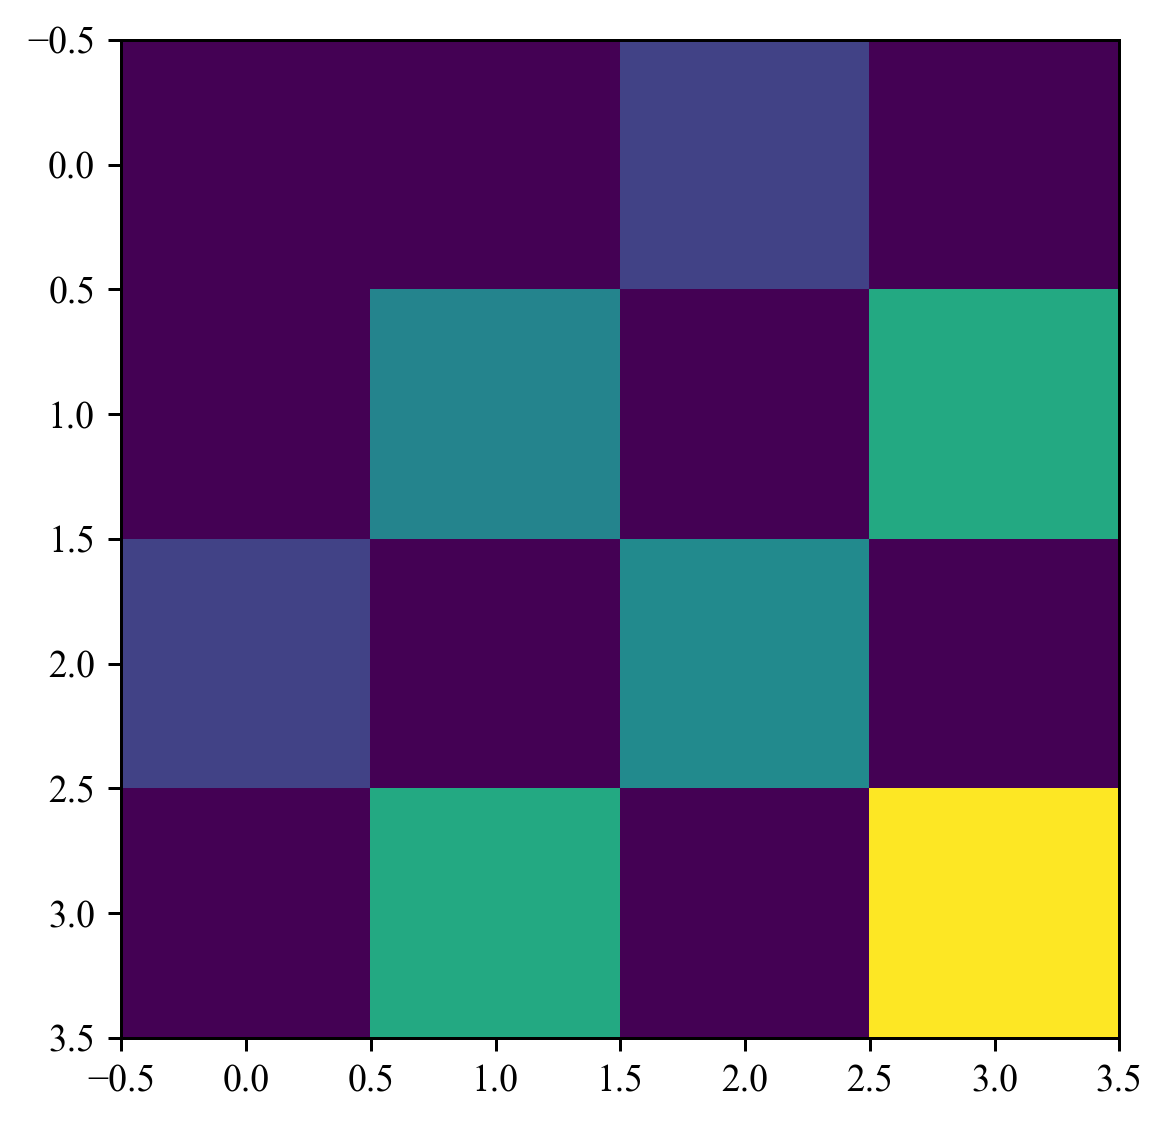

In [41]:
ren_op = renormalized_H_op(N, n)[0]
ren_basis = get_basis(n)
plt.imshow(np.real(generate_matrix(ren_op, ren_basis)))

In [42]:
renormalized_H_op(N, n)[0]

1.0 * a0^ a0^ a0^ a0^
2.849565686667622 * a0^ a0^ a0^ a0
3.5923247590513974 * a0^ a0^
-5.536050711865203 * a0^ a0^ a0 a0
11.737092068070018 * a0^ a0
2.849565686667622 * a0^ a0 a0 a0
3.5923247590513974 * a0 a0
1.0 * a0 a0 a0 a0
3.9998612759007734 * a0^ a0^ a0^ a0 a0 a0
8.552119535111565 * a0^ a0^ a0^ a0^ a0 a0 a0 a0
3.5581095542809806 * a0^ a0^ a0 a0 a0 a0
3.5581095542809806 * a0^ a0^ a0^ a0^ a0 a0